# Bayesian Regression - Introduction (Part 1)

Regression is one of the most common and basic supervised learning tasks in machine learning. Suppose we're given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates by using Pyro to implement Bayesian regression.

## Setup
Let's begin by importing the modules we'll need.

In [3]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
#assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

### Dataset 

The following example is adapted from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially.

In [4]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

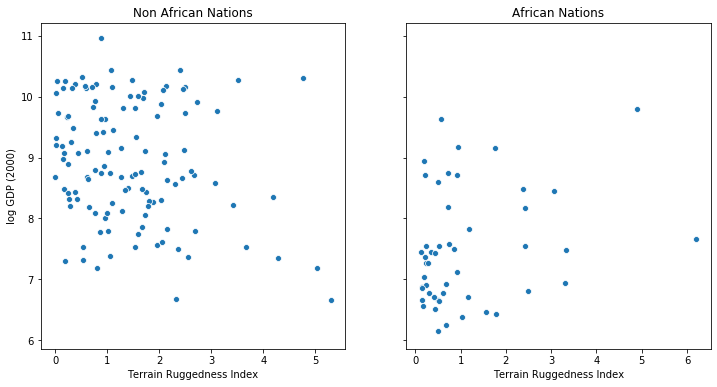

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

## Linear Regression
We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index.  Let's define our regression model. We'll use PyTorch's `nn.Module` for this.  Our input $X$ is a matrix of size $N \times 2$ and our output $y$ is a vector of size $2 \times 1$.  The function `nn.Linear(p, 1)` defines a linear transformation of the form $Xw + b$ where $w$ is the weight matrix and $b$ is the additive bias.  We include an extra `self.factor` term meant to capture the correlation between ruggedness and whether a country is in Africa.

Note that we can easily make this a logistic regression by adding a non-linearity in the `forward()` method.

In [6]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

p = 2  # number of features
regression_model = RegressionModel(p)

## Training
We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the `regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 500 iterations.

In [8]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 1000 if not smoke_test else 2
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print(name, param.data.numpy())

main()

[iteration 0050] loss: 147.8842
[iteration 0100] loss: 147.8816
[iteration 0150] loss: 147.8815
[iteration 0200] loss: 147.8815
[iteration 0250] loss: 147.8815
[iteration 0300] loss: 147.8815
[iteration 0350] loss: 147.8815
[iteration 0400] loss: 147.8815
[iteration 0450] loss: 147.8815
[iteration 0500] loss: 147.8815
[iteration 0550] loss: 147.8815
[iteration 0600] loss: 147.8815
[iteration 0650] loss: 147.8815
[iteration 0700] loss: 147.8815
[iteration 0750] loss: 147.8815
[iteration 0800] loss: 147.8815
[iteration 0850] loss: 147.8815
[iteration 0900] loss: 147.8815
[iteration 0950] loss: 147.8815
[iteration 1000] loss: 147.8826
Learned parameters:
factor 0.39245045
linear.weight [[-1.9489574  -0.20383939]]
linear.bias [9.222241]




[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over variables that are consistent with the observed data.

## Bayesian Regression

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

### `random_module()`

In order to do this, we'll 'lift' the parameters of our existing model to random variables. We can do this in Pyro via `random_module()`, which effectively takes a given `nn.Module` and turns it into a distribution over the same module; in our case, this will be a distribution over regressors. Specifically, each parameter in the original regression model is sampled from the provided prior. This allows us to repurpose vanilla regression models for use in the Bayesian setting. For example:
```python
loc = torch.zeros(1, 1)
scale = torch.ones(1, 1)
# define a unit normal prior
prior = Normal(loc, scale)
# overload the parameters in the regression module with samples from the prior
lifted_module = pyro.random_module("regression_module", nn, prior)
# sample a nn from the prior
sampled_reg_model = lifted_module()
```

### Model

We now have all the ingredients needed to specify our model. First we define priors over weights, biases, and `factor`. Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We wrap `regression_model` with `random_module` and sample an instance of the regressor, `lifted_reg_model`. We then run the regressor on `x_data`. Finally we use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`.

In [9]:
def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

### Guide

In order to do inference we're going to need a guide, i.e. a variational family of distributions.  We will use Pyro's [autoguide library](http://docs.pyro.ai/en/dev/contrib.autoguide.html) to automatically place Gaussians with diagonal covariance on all of the distributions in the model.  Under the hood, this defines a `guide` function with `Normal` distributions with learnable parameters corresponding to each `sample()` in the model.  Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/contrib.autoguide.html) for more information).   In [Part II](bayesian_regression_ii.ipynb) we will explore how to write guides by hand.

In [10]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

## Inference

To do inference we'll use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [11]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  The complete training loop is as follows:

In [12]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train()

[iteration 0001] loss: 18.3907
[iteration 0101] loss: 3.1146
[iteration 0201] loss: 3.1067
[iteration 0301] loss: 2.8602
[iteration 0401] loss: 2.7770
[iteration 0501] loss: 2.6181
[iteration 0601] loss: 2.4298
[iteration 0701] loss: 2.0160
[iteration 0801] loss: 1.7814
[iteration 0901] loss: 1.5811


In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-2.2026,  0.2936, -1.8873, -0.1607,  9.1753], requires_grad=True)
auto_scale tensor([0.2285, 0.0954, 0.1376, 0.0600, 0.1042], grad_fn=<AddBackward0>)


As you can see, instead of just point estimates, we now have uncertainty estimates (`auto_scale`) for our learned parameters.  Note that Autoguide packs the latent variables into a tensor, in this case, one entry per variable sampled in our model.

## Model Evaluation
To evaluate our model, we'll generate some predictive samples and look at the posteriors. Since our variational distribution is fully parameterized, we can just run the lifted model forward.  We wrap the model with a `Delta` distribution in order to register the values with Pyro.  We then store the execution traces in the `posterior` object with `svi.run()`.

In [14]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)


In [15]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

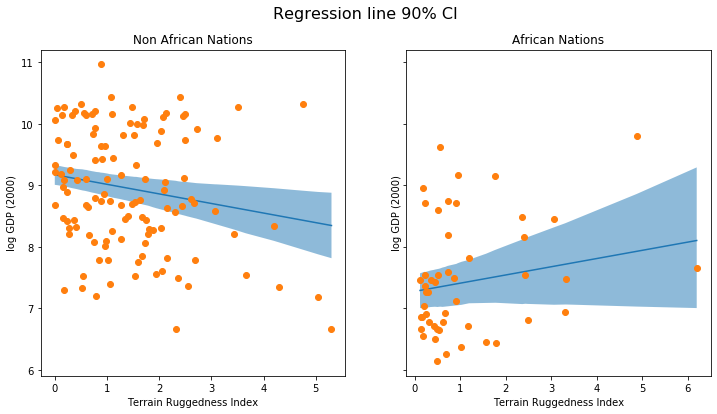

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

The above figure shows the uncertainty in our estimate of the regression line. Note that for lower values of ruggedness there are many more data points, and as such, lesser wiggle room for the line of best fit. This is reflected in the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by `sigma`! Let us do so next.

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

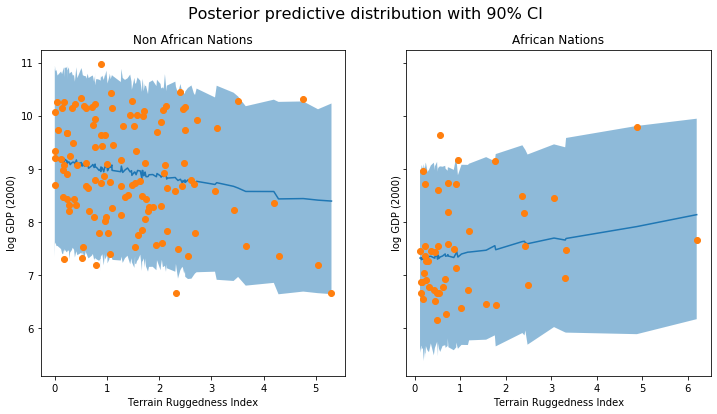

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is usually a good idea to do such posterior predictive checks to see if our model gives valid predictions.

Text(0.5, 0.98, 'Density of Slope : log(GDP) vs. Terrain Ruggedness')

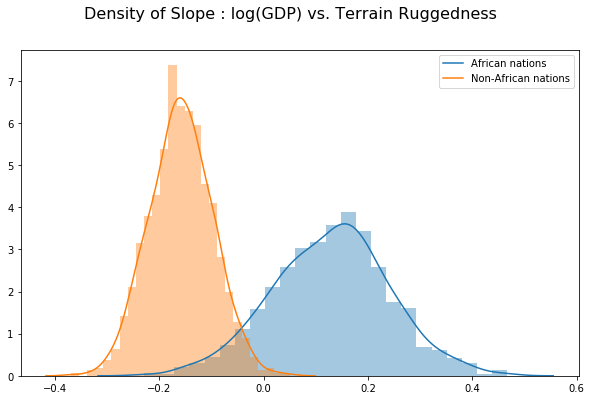

In [15]:
# we need to prepend `module$$$` to all parameters of nn.Modules since
# that is how they are stored in the ParamStore
weight = get_marginal(posterior, ['module$$$linear.weight']).squeeze(1).squeeze(1)
factor = get_marginal(posterior, ['module$$$factor'])
gamma_within_africa = weight[:, 1] + factor.squeeze(1)
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)

In the next section, we'll look at how to write guides for variational inference as well as compare the results with inference via HMC.

See an example with a toy dataset on [Github](https://github.com/uber/pyro/blob/dev/examples/bayesian_regression.py).

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012